In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [2]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [3]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

In [4]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

In [5]:
fluxes = pd.read_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv')

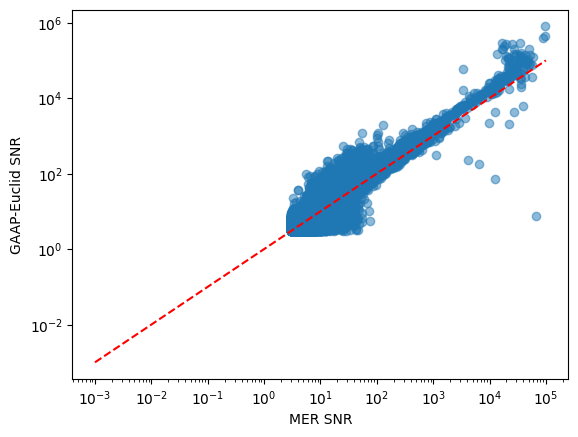

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.6420471127788201
Average SNR improvement factor (GAAP-Euclid / MER): 1.220732650164073


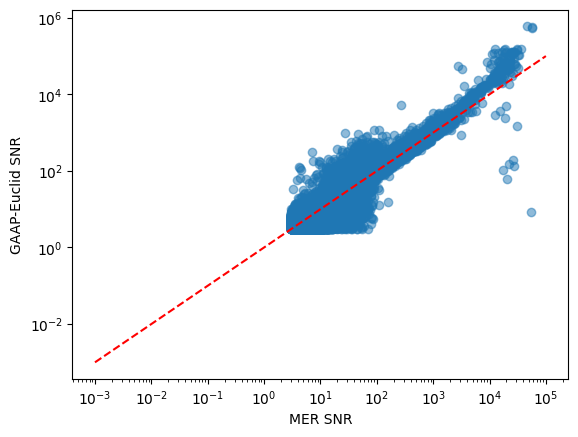

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.5245024722422621
Average SNR improvement factor (GAAP-Euclid / MER): 1.082110383354374


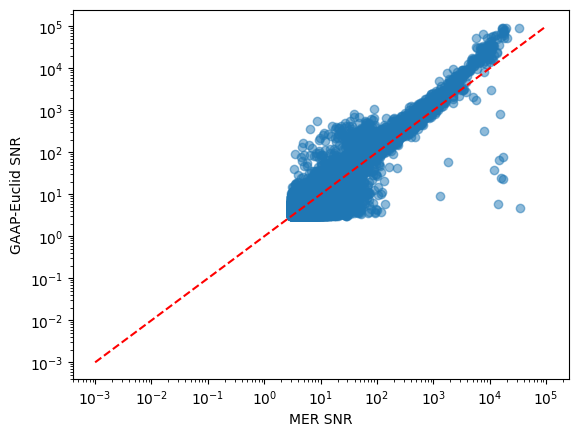

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.6527629471436198
Average SNR improvement factor (GAAP-Euclid / MER): 1.2572702724554425


In [6]:
for filter in ['G', 'R', 'I']:
    snr_meer = cat[f'FLUX_{filter}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter}_EXT_DECAM_4FWHM_APER']
    snr_gaap_euclid = fluxes[f'flux_DES-{filter}']/fluxes[f'flux_DES-{filter}_sigma']
    cutoff_snr = 3
    mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_euclid[mask],
                alpha=0.5)
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Euclid SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
    print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))

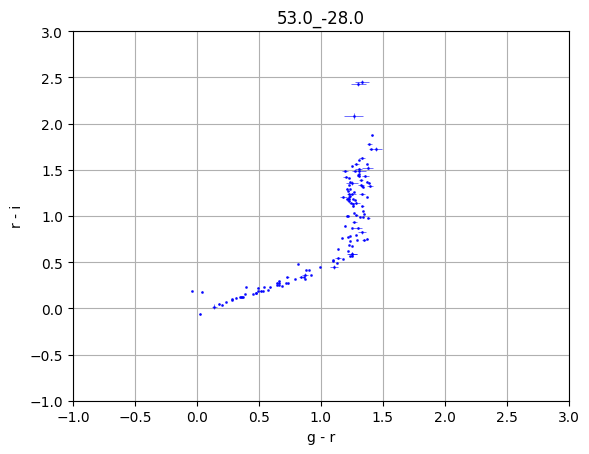

In [7]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
gaap_error = xerr**2 + yerr**2
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.show()

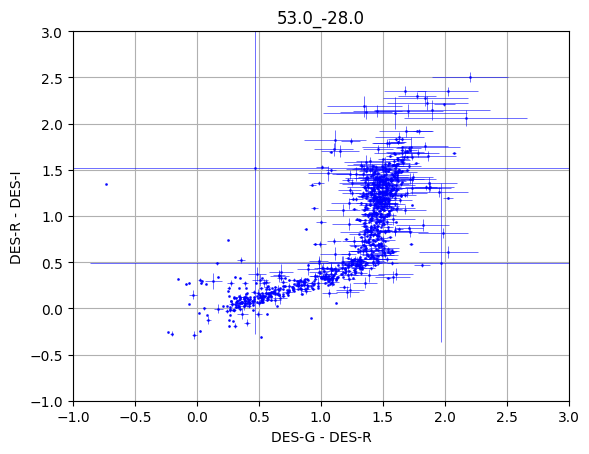

In [8]:
filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

gaap_error = xerr**2 + yerr**2
# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.show()

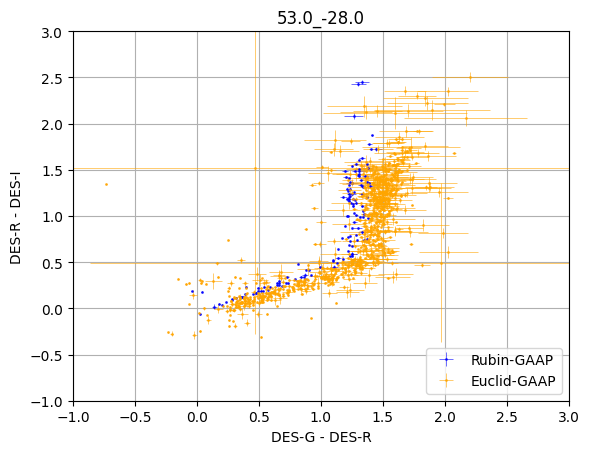

In [9]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
gaap_error = xerr**2 + yerr**2
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='Rubin-GAAP'
)

filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

gaap_error = xerr**2 + yerr**2
# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='Euclid-GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.legend()
plt.show()

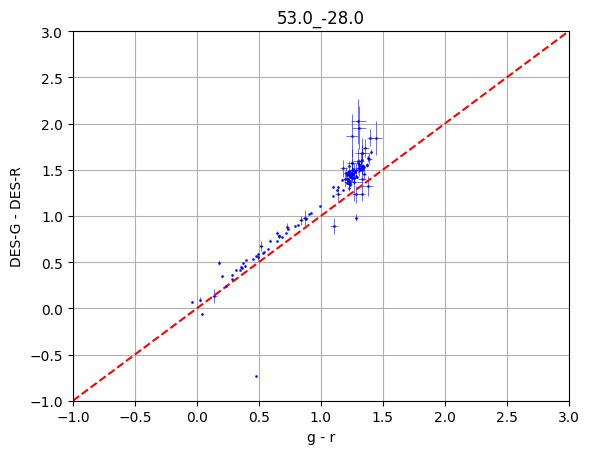

In [10]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_DES-G'   # e.g., master_table column name
filter_4 = 'flux_DES-R'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
gaap_error = xerr**2 + yerr**2
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='Rubin-GAAP'
)
plt.plot([-1, 3], [-1, 3], 'r--')
plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.show()

In [11]:
fluxes

,ra,dec,flux_u,flux_u_sigma,flux_g,flux_g_sigma,flux_r,flux_r_sigma,flux_i,flux_i_sigma,...,flux_DES-R_sigma,flux_DES-I,flux_DES-I_sigma,flux_NIR-Y,flux_NIR-Y_sigma,flux_NIR-J,flux_NIR-J_sigma,flux_NIR-H,flux_NIR-H_sigma,aperture_size
0,53.157185,-28.254257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,144.920945,32.004365,167.284667,43.209291,256.340075,36.495775,362.022114,43.614250,0.7
1,52.816362,-28.254012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,110.075521,32.004365,310.429621,43.209291,133.900762,36.495775,160.305917,43.614250,0.7
2,52.707227,-28.253847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,125.154173,32.004365,169.448698,43.209291,199.329340,36.495775,220.118070,43.614250,0.7
3,52.761280,-28.253924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,311.009526,32.004365,472.356272,43.209291,619.182634,36.495775,760.402918,43.614250,0.7
4,53.233772,-28.253921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,302.516413,32.004365,283.355284,43.209291,465.322781,36.495775,516.348886,43.614250,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96159,52.762204,-27.748261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.954716,-11.132873,15.875480,6.582555,26.239643,-27.519208,21.953951,37.295628,26.171234,1.1
96160,53.002813,-27.748525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,-58.673882,32.004365,-11.503357,43.209291,4.471902,36.495775,87.493670,43.614250,0.7
96161,53.002641,-27.748209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,58.480108,32.004365,15.963216,43.209291,-20.420985,36.495775,6.639498,43.614250,0.7
96162,52.751111,-27.748058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.859918,-61.633438,32.004365,102.500522,43.209291,203.351116,36.495775,102.128613,43.614250,0.7
